In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# data preparation
# first randomize the training data. 
# then split the training data and labels in X_train and y_train respectively
# try processing on the data - normalize and reshape them


In [3]:
train = train.sample(frac=1)
train.head(n=4)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
38732,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3686,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30090,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31205,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_train = train['label']

In [6]:
del train['label']
X_train = train

In [7]:
X_train.head(n=4)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
38732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_train /= 255
test /= 255

In [9]:
X_train = X_train.values.reshape(-1,28,28,1).astype('float32')
test = test.values.reshape(-1,28,28,1).astype('float32')

In [10]:
X_train.dtype

dtype('float32')

In [11]:
y_train = to_categorical(y_train,num_classes=10)

In [12]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [13]:
y_train = y_train.astype('int32')

In [14]:
random_seed = 2

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.1,random_state = random_seed)

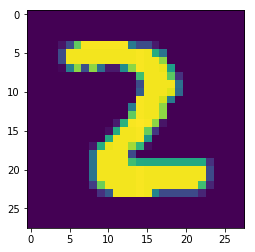

In [16]:
g = plt.imshow(X_train[33599][:,:,0])

In [17]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [36]:
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

In [37]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

#earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [39]:
epochs = 30
batch_size = 100


In [40]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [41]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 13s - loss: 0.0304 - acc: 0.9910 - val_loss: 0.0211 - val_acc: 0.9948
Epoch 2/30
 - 11s - loss: 0.0322 - acc: 0.9903 - val_loss: 0.0181 - val_acc: 0.9945
Epoch 3/30
 - 11s - loss: 0.0308 - acc: 0.9908 - val_loss: 0.0182 - val_acc: 0.9950
Epoch 4/30
 - 11s - loss: 0.0290 - acc: 0.9909 - val_loss: 0.0185 - val_acc: 0.9955
Epoch 5/30
 - 11s - loss: 0.0289 - acc: 0.9910 - val_loss: 0.0184 - val_acc: 0.9960
Epoch 6/30
 - 12s - loss: 0.0262 - acc: 0.9915 - val_loss: 0.0181 - val_acc: 0.9964
Epoch 7/30
 - 11s - loss: 0.0327 - acc: 0.9907 - val_loss: 0.0240 - val_acc: 0.9948
Epoch 8/30
 - 12s - loss: 0.0297 - acc: 0.9911 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 9/30
 - 12s - loss: 0.0291 - acc: 0.9913 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 10/30

Epoch 00010: reducing learning rate to 0.0005000000237487257.
 - 12s - loss: 0.0300 - acc: 0.9911 - val_loss: 0.0165 - val_acc: 0.9950
Epoch 11/30
 - 12s - loss: 0.0228 - acc: 0.9929 - val_loss: 0.0159 - val_acc: 0.9955
Epoch 12/30

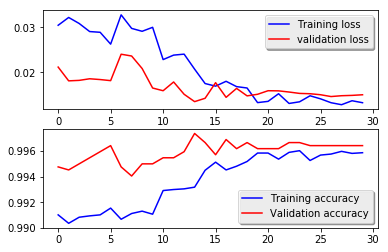

In [42]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [43]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [44]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_submit.csv",index=False)

In [45]:
data = pd.read_csv('cnn_submit.csv')

In [46]:
data.head(n=5)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [47]:
data

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
